In [1]:
import sys
import torch
from matplotlib import pyplot as plt
import numpy as np

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP

from data_generators import *
from positional_encoders import *
from plotters import *

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

In [2]:
dx, dy, dg, dph, dpe = 1, 1, 1, 0, 27
num_demos, num_test = 180, 20
num_trajs = num_demos + num_test
t_steps = 1200
n_max, m_max = 100, 100
max_freq=5

trajectories, _, freqs = generate_cyclic_trajectories_with_random_cycles(num_trajs=num_trajs, max_freq=max_freq, freq=True)

perm_ids = torch.randperm(num_trajs)
train_ids, test_ids = perm_ids[:num_demos], perm_ids[num_demos:]

all_x = torch.linspace(0, 1, t_steps).unsqueeze(-1).unsqueeze(0).repeat(num_trajs,1,1)

x_train, x_test = all_x[train_ids], all_x[test_ids]
y_train, y_test = trajectories[train_ids], trajectories[test_ids]
g_train, g_test = freqs[train_ids]/max_freq, freqs[test_ids]/max_freq

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, g_train shape: {g_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}, g_test shape: {g_test.shape}")

x_train shape: torch.Size([180, 1200, 1]), y_train shape: torch.Size([180, 1200, 1]), g_train shape: torch.Size([180, 1])
x_test shape: torch.Size([20, 1200, 1]), y_test shape: torch.Size([20, 1200, 1]), g_test shape: torch.Size([20, 1])


In [3]:
pe = generate_positional_encoding(t_steps, dpe)

In [4]:
batch_size = 20

enc_dims = [256,256]
dec_dims = [256,256]

m0_ = CNMP(input_dim=dx+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
opt0 = torch.optim.Adam(lr=3e-4, params=m0_.parameters())

m1_ = CNMP(input_dim=dpe+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
opt1 = torch.optim.Adam(lr=3e-4, params=m1_.parameters())

pytorch_total_params = sum(p.numel() for p in m0_.parameters())
print('Bare: ', pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in m1_.parameters())
print('PE: ', pytorch_total_params)

if torch.__version__ >= "2.0":
    m0, m1 = torch.compile(m0_), torch.compile(m1_)
else:
    m0, m1 = m0_, m1_


# save network architectures in a txt file:
with open('networks.txt', 'w') as f:
    f.write(str(m0_) + '\n')
    f.write(str(m1_) + '\n')

Bare:  133634
PE:  146946


In [5]:
obs0 = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
tar_x0 = torch.zeros((batch_size, m_max, dx+dg), dtype=torch.float32, device=device)

obs1 = torch.zeros((batch_size, n_max, dpe+dg+dy), dtype=torch.float32, device=device)
tar_x1 = torch.zeros((batch_size, m_max, dpe+dg), dtype=torch.float32, device=device)

tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    global obs0, tar_x0, obs1, tar_x1, tar_y, obs_mask, tar_mask
    obs0.fill_(0)
    tar_x0.fill_(0)
    obs1.fill_(0)
    tar_x1.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max+1, (1,)).item()
        m = torch.randint(1, m_max+1, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]

        obs0[i, :n, :dx] = x_train[traj_id, n_ids]  # t
        obs0[i, :n, dx:dx+dg] = g_train[traj_id]  # gamma
        obs0[i, :n, dx+dg:] = traj[n_ids]  # SM(t)

        obs1[i, :n, :dpe] = pe[n_ids]  # PE(t)
        obs1[i, :n, dpe:dpe+dg] = g_train[traj_id]  # gamma
        obs1[i, :n, dpe+dg:] = traj[n_ids]  # SM(t)

        obs_mask[i, :n] = True
        
        tar_x0[i, :m, :dx] = x_train[traj_id, m_ids]
        tar_x0[i, :m, dx:] = g_train[traj_id]
        tar_x1[i, :m, :dpe] = pe[m_ids]
        tar_x1[i, :m, dpe:] = g_train[traj_id]        
        
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True


test_obs0 = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
test_tar_x0 = torch.zeros((batch_size, t_steps, dx+dg), dtype=torch.float32, device=device)

test_obs1 = torch.zeros((batch_size, n_max, dpe+dg+dy), dtype=torch.float32, device=device)
test_tar_x1 = torch.zeros((batch_size, t_steps, dpe+dg), dtype=torch.float32, device=device)

test_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
test_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
last_obs_vals = torch.zeros((batch_size, n_max, dx), dtype=torch.int32, device=device)  # only for plotting

def prepare_masked_test_batch(t: list, traj_ids: list, fixed_ind=None):
    global test_obs0, test_tar_x0, test_obs1, test_tar_x1, test_tar_y, test_obs_mask, last_obs_vals
    test_obs0.fill_(0)
    test_tar_x0.fill_(0)
    test_obs1.fill_(0)
    test_tar_x1.fill_(0)
    test_tar_y.fill_(0)
    test_obs_mask.fill_(False)
    last_obs_vals.fill_(0)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        # n = num_peaks #torch.randint(5, n_max, (1,)).item()
        n = torch.randint(1, n_max+1, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)

        if fixed_ind != None:
            for p in range(n):
                n_ids[p] = fixed_ind[i, p]
            # n_ids[-1] = fixed_ind[i]

        test_obs0[i, :n, :dx] = x_test[traj_id, n_ids]  # t
        test_obs0[i, :n, dx:dx+dg] = g_test[traj_id]
        test_obs0[i, :n, dx+dg:] = traj[n_ids]  # SM(t)

        test_obs1[i, :n, :dpe] = pe[n_ids]  # PE(t)
        test_obs1[i, :n, dpe:dpe+dg] = g_test[traj_id]
        test_obs1[i, :n, dpe+dg:] = traj[n_ids]

        last_obs_vals[i, :n] = n_ids.unsqueeze(-1)
        test_obs_mask[i, :n] = True
        
        test_tar_x0[i, :, :dx] = x_test[traj_id, m_ids]
        test_tar_x1[i, :, :dpe] = pe[m_ids]

        test_tar_y[i] = traj[m_ids]

In [ ]:
import time
import os


timestamp = int(time.time())
root_folder = f'../outputs/comparison/mind_change/freq/bare_pe_promp_gmm/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(x_train, f'{root_folder}x.pt')
torch.save(y_train, f'{root_folder}y.pt')
torch.save(g_train, f'{root_folder}g.pt')
torch.save(x_test, f'{root_folder}x_test.pt')
torch.save(y_test, f'{root_folder}y_test.pt')
torch.save(g_test, f'{root_folder}g_test.pt')

with open(f'{root_folder}networks.txt', 'w') as f:
    f.write(str(m0_) + '\n')
    f.write(str(m1_) + '\n')


epochs = 500_000
epoch_iter = num_demos // batch_size
test_epoch_iter = num_test//batch_size
avg_loss0, avg_loss1 = 0, 0
loss_report_interval = 2000
test_per_epoch = 2000
min_test_loss0, min_test_loss1 = 1000000, 1000000
mse_loss = torch.nn.MSELoss()

plot_test = False

l0, l1 = [], []

for epoch in range(epochs):
    epoch_loss0, epoch_loss1 = 0, 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        opt0.zero_grad()
        pred0 = m0(obs0, tar_x0, obs_mask)
        loss0 = m0.loss(pred0, tar_y, tar_mask)
        loss0.backward()
        opt0.step()

        epoch_loss0 += loss0.item()


        opt1.zero_grad()
        pred1 = m1(obs1, tar_x1, obs_mask)
        loss1 = m1.loss(pred1, tar_y, tar_mask)
        loss1.backward()
        opt1.step()

        epoch_loss1 += loss1.item()


    if epoch % test_per_epoch == 0:# and epoch > 0:
        test_traj_ids = torch.randperm(num_test)[:batch_size*test_epoch_iter].chunk(test_epoch_iter)
        test_loss0, test_loss1 = 0, 0

        for j in range(test_epoch_iter):
            prepare_masked_test_batch(y_test, test_traj_ids[j])

            pred0 = m0.val(test_obs0, test_tar_x0, test_obs_mask)
            pred1 = m1.val(test_obs1, test_tar_x1, test_obs_mask)
            
            if plot_test:
                for k in range(batch_size):
                    current_n = test_obs_mask[k].sum().item()
                    plt.scatter(last_obs_vals[k, :current_n, :dx].cpu().numpy(), test_obs0[k, :current_n, dx+dg:].cpu().numpy(), label='Condition')
                    plt.plot(test_tar_y[k, :, 0].cpu().numpy(), label=f"Groundtruth")
                    plt.plot(pred0[k, :, 0].cpu().numpy(), label=f"Prediction")
                    
                    plt.legend(loc='upper left')
                    plt.title(f'Epoch: {epoch}', fontsize=20)
                    plt.savefig(f'{img_folder}{epoch}_{test_traj_ids[j][k]}_bare.png')
                    plt.clf()

                    plt.scatter(last_obs_vals[k, :current_n, :dx].cpu().numpy(), test_obs1[k, :current_n, dpe+dg:].cpu().numpy(), label='Condition')
                    plt.plot(test_tar_y[k, :, 0].cpu().numpy(), label=f"Groundtruth")
                    plt.plot(pred1[k, :, 0].cpu().numpy(), label=f"Prediction")
                    
                    plt.legend(loc='upper left')
                    plt.title(f'Epoch: {epoch}', fontsize=20)
                    plt.savefig(f'{img_folder}{epoch}_{test_traj_ids[j][k]}_pe.png')
                    plt.clf()
                    

            test_loss0 += mse_loss(pred0[:, :, :m0.output_dim], test_tar_y).item()
            test_loss1 += mse_loss(pred1[:, :, :m1.output_dim], test_tar_y).item()
        
        test_loss0 /= test_epoch_iter
        test_loss1 /= test_epoch_iter
            
        if test_loss0 < min_test_loss0:
            min_test_loss0 = test_loss0
            print(f'New BARE best: {min_test_loss0}, PE best: {min_test_loss1}')
            torch.save(m0_.state_dict(), f'{root_folder}saved_models/bare.pt')

        if test_loss1 < min_test_loss1:
            min_test_loss1 = test_loss1
            print(f'New PE best: {min_test_loss1}, BARE best: {min_test_loss0}')
            torch.save(m1_.state_dict(), f'{root_folder}saved_models/pe.pt')


    epoch_loss0 /= epoch_iter
    epoch_loss1 /= epoch_iter

    avg_loss0 += epoch_loss0
    avg_loss1 += epoch_loss1

    l0.append(epoch_loss0)
    l1.append(epoch_loss1)

    if epoch % loss_report_interval == 0:
        print("Epoch: {}, Losses: BARE: {}, PE: {}".format(epoch, avg_loss0/loss_report_interval, avg_loss1/loss_report_interval))
        avg_loss0, avg_loss1 = 0, 0


New BARE best: 0.4822556972503662, PE best: 1000000
New PE best: 0.4849261939525604, BARE best: 0.4822556972503662
Epoch: 0, Losses: BARE: 0.0005305471817652384, PE: 0.0005306554966502719
New BARE best: 0.35028937458992004, PE best: 0.4849261939525604
New PE best: 0.13184528052806854, BARE best: 0.35028937458992004
Epoch: 2000, Losses: BARE: 0.7213972805948586, PE: 0.1838707680564945
New PE best: 0.11200575530529022, BARE best: 0.35028937458992004
Epoch: 4000, Losses: BARE: 0.496643725871025, PE: -0.4189066097473949
New PE best: 0.10005523264408112, BARE best: 0.35028937458992004
Epoch: 6000, Losses: BARE: 0.3936062699438893, PE: -0.688123720165172
New PE best: 0.0560997873544693, BARE best: 0.35028937458992004
Epoch: 8000, Losses: BARE: 0.28441547008363305, PE: -0.8802284682662621
New PE best: 0.03611304610967636, BARE best: 0.35028937458992004
Epoch: 10000, Losses: BARE: 0.18043815345508896, PE: -1.0179374527293787
New PE best: 0.025981342419981956, BARE best: 0.35028937458992004
Epo

In [7]:
torch.save(l0, f'{root_folder}losses_bare.pt')
torch.save(l1, f'{root_folder}losses_pe.pt')

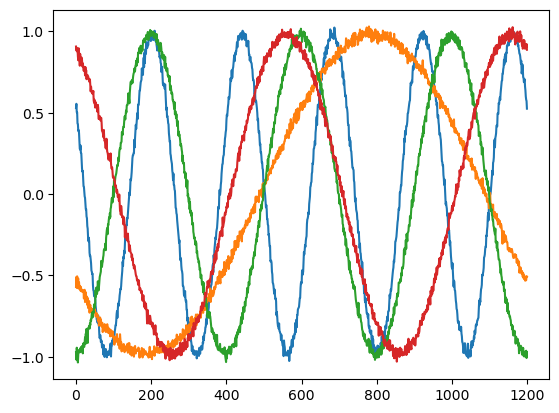

In [8]:
import matplotlib.pyplot as plt

# plot y_train
for i in range(0, num_demos, 45):
    plt.plot(y_train[i].cpu().numpy())

In [9]:
# from gmr import GMM

# X = y_train.numpy().reshape(num_demos * t_steps, dy)  # Shape: (180 * 1200, 1)
# frequencies = g_train.numpy().repeat(t_steps, axis=0)  # Shape: (180 * 1200, 1)
# time_steps = np.tile(np.linspace(0, 1, t_steps), num_demos).reshape(-1, 1)  # Normalize time

# # Combine all inputs: time_steps, frequencies, and trajectories
# inputs = np.hstack((time_steps, frequencies))  # Shape: (180 * 1200, 2)
# data = np.hstack((inputs, X))  # Shape: (180 * 1200, 3)

# # Fit a GMM
# gmm = GMM(n_components=5, random_state=42)
# gmm.from_samples(data)

# # Condition on frequency to model trajectories
# def generate_trajectory(frequency, num_steps=1200):
#     time_steps = np.linspace(0, 1, num_steps).reshape(-1, 1)
#     inputs = np.hstack((time_steps, np.full((num_steps, 1), frequency)))
#     predictions = gmm.condition(np.array([0]), inputs)  # Condition on time_steps and frequency
#     return predictions

# # Example: Generate a trajectory for a frequency of 3 cycles
# gmm_trajectory = generate_trajectory(frequency=3/max_freq)

In [10]:
# from gmr import GMM
# from movement_primitives.promp import ProMP

# n_weights_per_dim = 30

# x = np.linspace(0, 1, t_steps)
# x = np.concatenate([x[np.newaxis, ...]] * num_demos, axis=0)

# Ts = np.array([np.linspace(0, 1, t_steps) for _ in range(num_demos)])  # Shape: (num_demos, t_steps)
# Ys = y_train.numpy()  # Shape: (num_demos, t_steps, dy)

# # Initialize and train ProMP
# promp = ProMP(n_dims=dy, n_weights_per_dim=n_weights_per_dim)
# promp.imitate(Ts, Ys, n_iter=1000, min_delta=1e-8, verbose=1)  # Train ProMP

# # Extract weights from trained ProMP
# weights = np.empty((num_demos, dy * n_weights_per_dim))
# for i in range(num_demos):
#     weights[i] = promp.weights(Ts[i], Ys[i])  # Extract weights for each trajectory

# # Train GMM with context (frequencies) and weights
# X = np.hstack((g_train, weights))  # Combine frequency (context) with weights
# gmm = GMM(n_components=5, random_state=42)
# gmm.from_samples(X)

# # Query GMM for conditional weights given a specific frequency
# freq_query = np.array([[3 / max_freq]])  # Example frequency query
# conditional_weight_distribution = gmm.condition(np.arange(1), freq_query).to_mvn()

# # Update the trained ProMP's weight distribution
# promp.from_weight_distribution(
#     conditional_weight_distribution.mean,
#     conditional_weight_distribution.covariance
# )

# # Add conditions and generate trajectories
# cond_point = np.array([0.95])  # Example condition point
# t = 0  # Example time step
# promp.condition_position(cond_point, t=t)

# # Generate trajectory directly from the trained ProMP
# promp_trajectory = promp.sample_trajectories(x[0], 1, np.random.RandomState(seed=1234))[0]

In [11]:
# plt.plot(promp_trajectory)

In [13]:
from gmr import GMM
from movement_primitives.promp import ProMP

num_promps = 30

n_weights_per_dim = 30

x = np.linspace(0, 1, t_steps)
x = np.concatenate([x[np.newaxis, ...]] * num_demos, axis=0)

Ts = np.array([np.linspace(0, 1, t_steps) for _ in range(num_demos)])  # Shape: (num_demos, t_steps)
Ys = y_train.numpy()  # Shape: (num_demos, t_steps, dy)

promps = []
for i in range(num_promps - 2):
    promps.append(ProMP(n_dims=dy, n_weights_per_dim=i + 2))  # Vary weights
promps.append(ProMP(n_dims=dy, n_weights_per_dim=40))  # Fixed higher number
promps.append(ProMP(n_dims=dy, n_weights_per_dim=50))  # Fixed higher number

# Train each ProMP and collect weights
gmm_list = []  # To store GMM models for each ProMP
for promp in promps:
    promp.imitate(Ts, Ys, n_iter=1000, min_delta=1e-6, verbose=1)  # Train ProMP

    # Extract weights from the ProMP
    n_weights_per_dim = promp.n_weights_per_dim
    weights = np.empty((num_demos, dy * n_weights_per_dim))
    for i in range(num_demos):
        weights[i] = promp.weights(Ts[i], Ys[i])

    # Train GMM with context (frequencies) and weights
    X = np.hstack((g_train, weights))  # Combine frequency (context) with weights
    gmm = GMM(n_components=5, random_state=42)
    gmm.from_samples(X)
    gmm_list.append(gmm)  # Store GMM for this ProMP


Iteration 0001: delta = 0.000548604
Iteration 0002: delta = 1.45353e-05
Iteration 0003: delta = 1.99079e-10
Iteration 0001: delta = 0.025632
Iteration 0002: delta = 0.00176448
Iteration 0003: delta = 8.90941e-09
Iteration 0001: delta = 0.0375127
Iteration 0002: delta = 0.00365056
Iteration 0003: delta = 1.17478e-08
Iteration 0001: delta = 0.051479
Iteration 0002: delta = 0.00904434
Iteration 0003: delta = 2.47403e-08
Iteration 0001: delta = 0.0782258
Iteration 0002: delta = 0.0190267
Iteration 0003: delta = 5.03907e-08
Iteration 0001: delta = 0.081758
Iteration 0002: delta = 0.0289637
Iteration 0003: delta = 4.40076e-08
Iteration 0001: delta = 0.116724
Iteration 0002: delta = 0.0465211
Iteration 0003: delta = 8.16961e-08
Iteration 0001: delta = 0.136295
Iteration 0002: delta = 0.0572321
Iteration 0003: delta = 8.65276e-08
Iteration 0001: delta = 0.139672
Iteration 0002: delta = 0.0561493
Iteration 0003: delta = 7.72686e-08
Iteration 0001: delta = 0.140481
Iteration 0002: delta = 0.0536

In [14]:
promp_trajs = []
for idx, (promp, gmm) in enumerate(zip(promps, gmm_list)):
    freq_query = np.array([[3 / max_freq]])  # Example frequency query
    conditional_weight_distribution = gmm.condition(np.arange(1), freq_query).to_mvn()

    # Update the trained ProMP's weight distribution
    promp.from_weight_distribution(
        conditional_weight_distribution.mean,
        conditional_weight_distribution.covariance
    )

    # Add conditions and generate trajectories
    cond_point = np.array([0.95])  # Example condition point
    t = 0  # Example time step
    promp.condition_position(cond_point, t=t)

    # Generate trajectory directly from the trained ProMP
    promp_trajectory = promp.sample_trajectories(x[0], 1, np.random.RandomState(seed=1234))[0]
    promp_trajs.append(promp_trajectory)

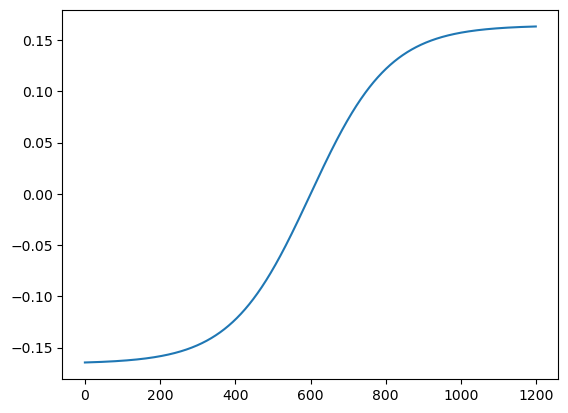

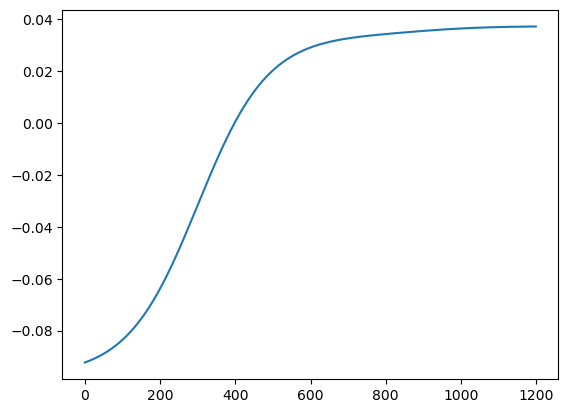

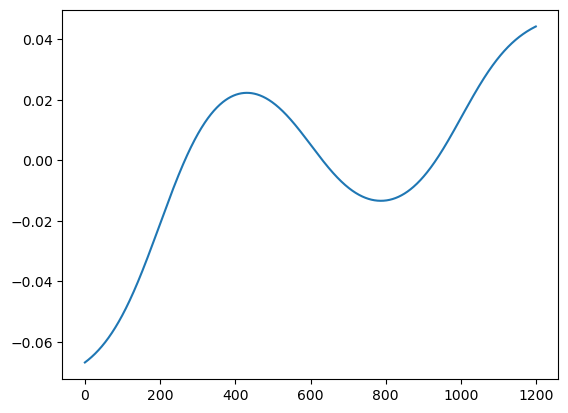

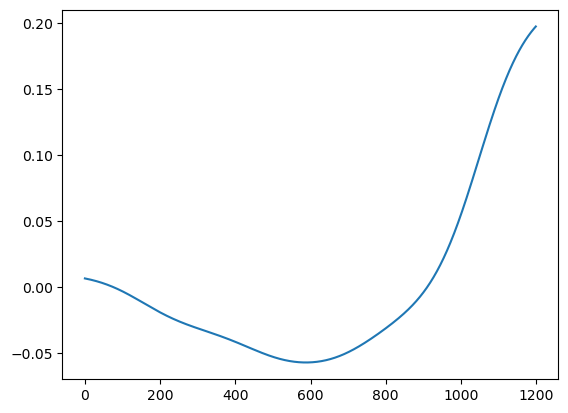

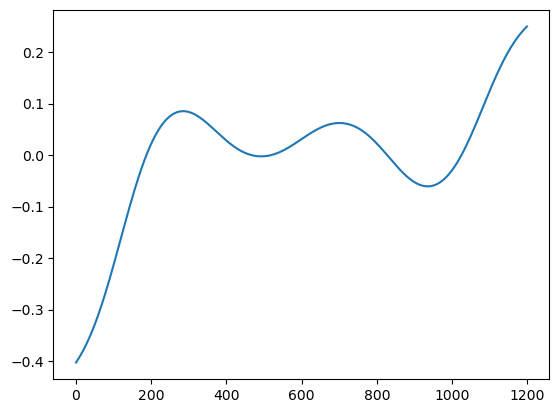

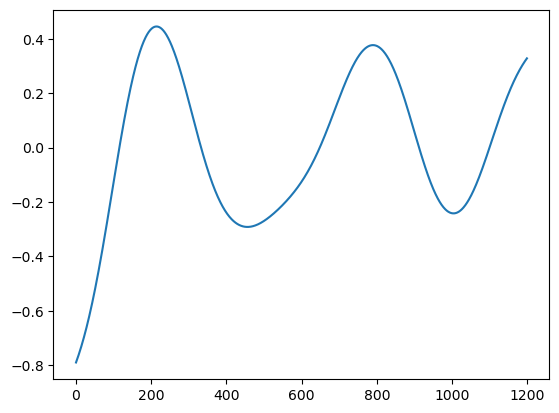

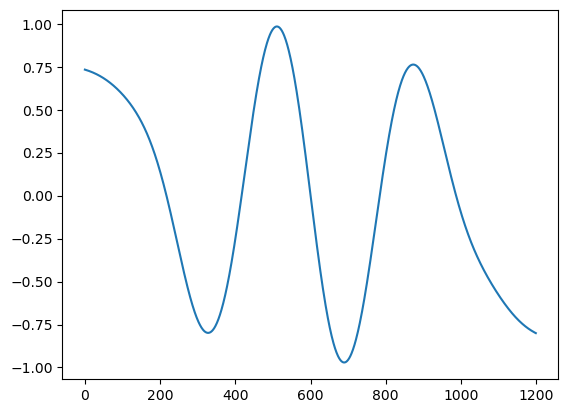

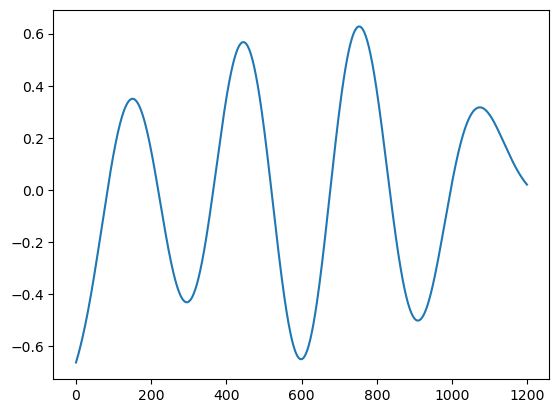

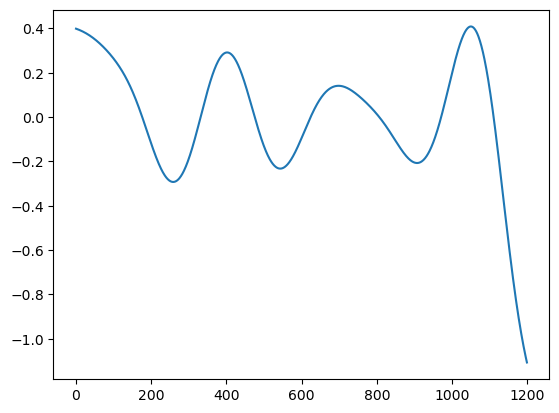

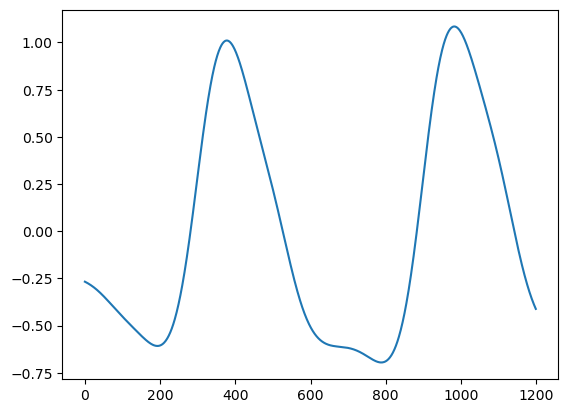

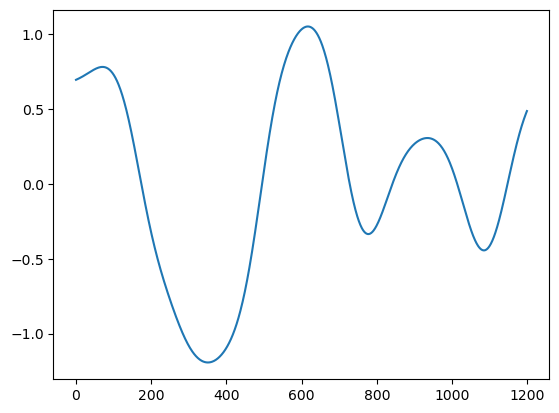

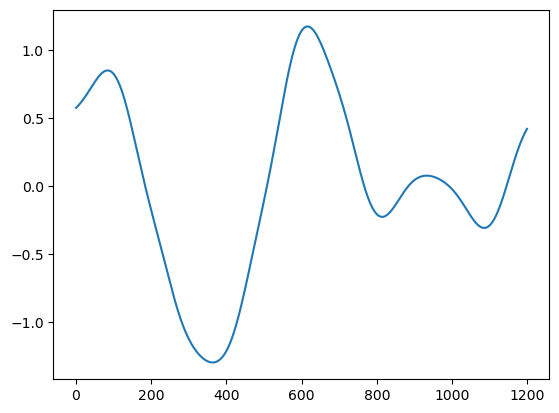

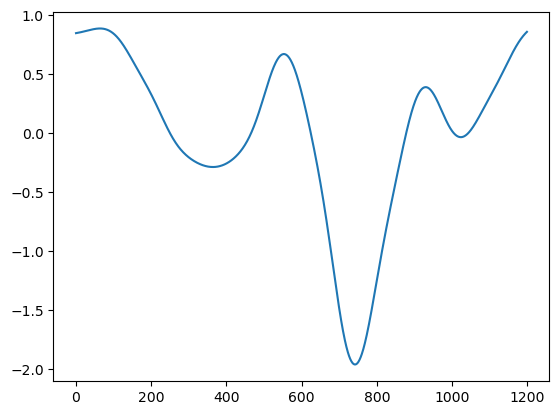

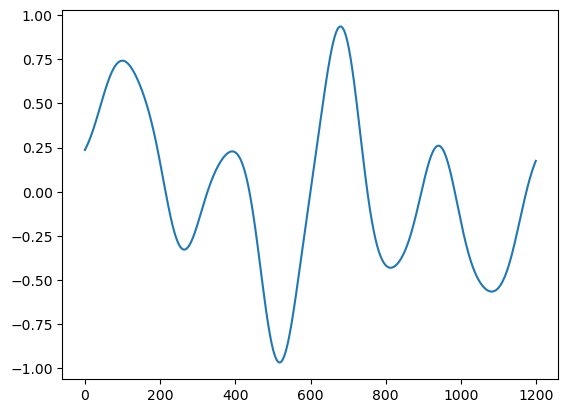

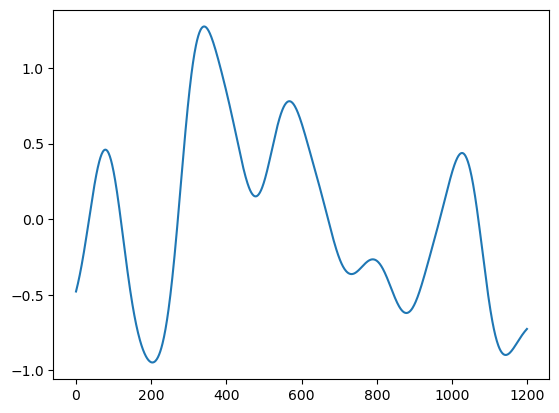

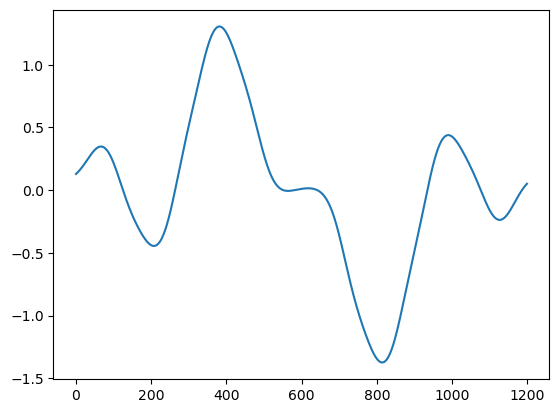

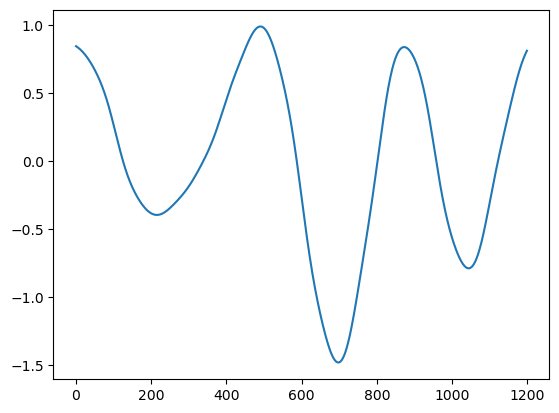

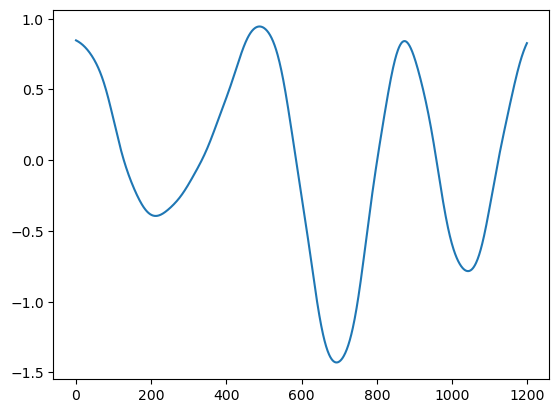

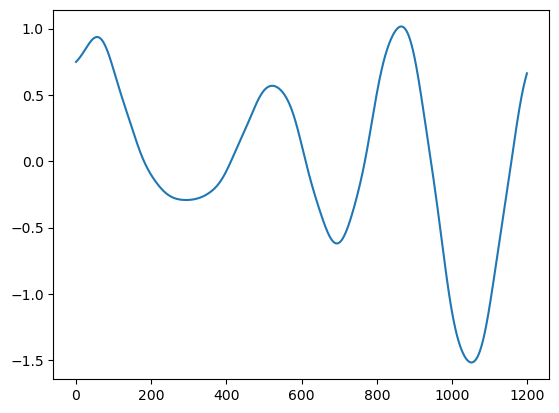

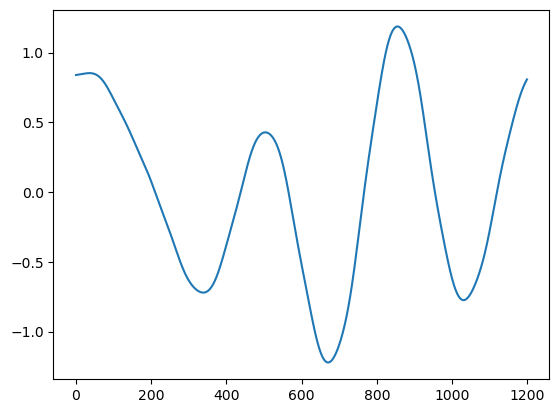

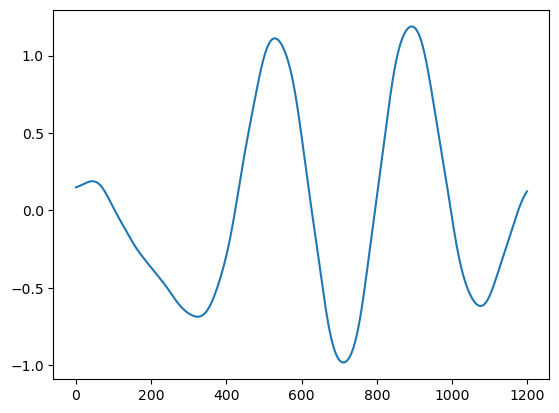

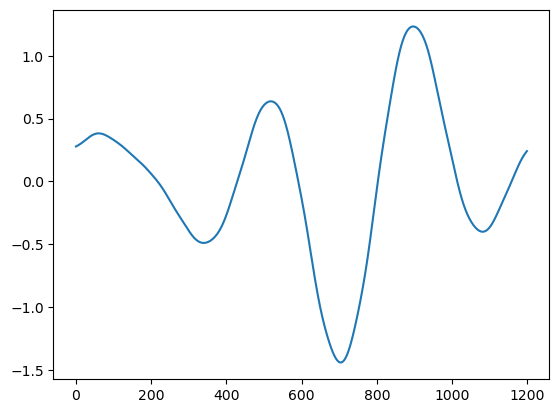

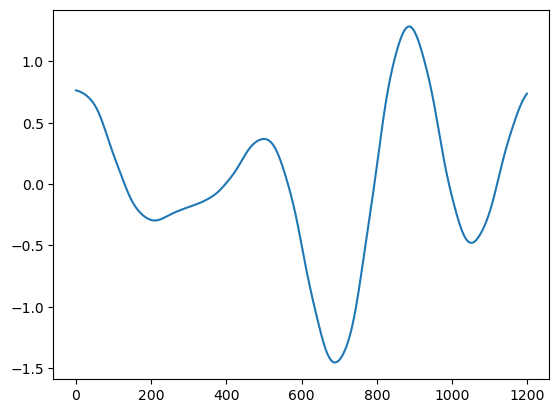

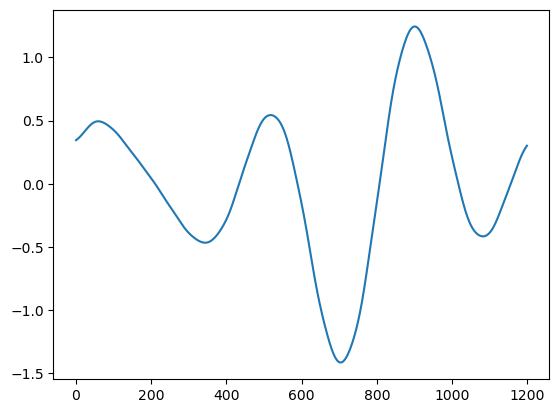

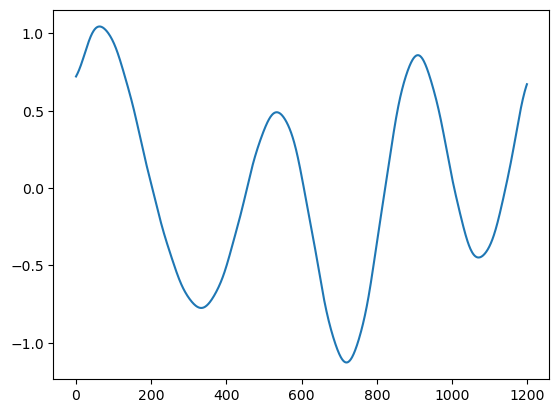

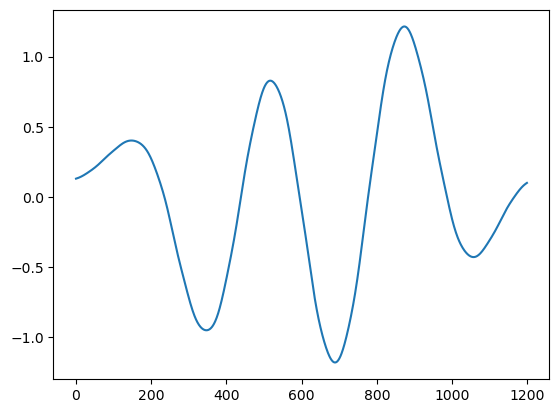

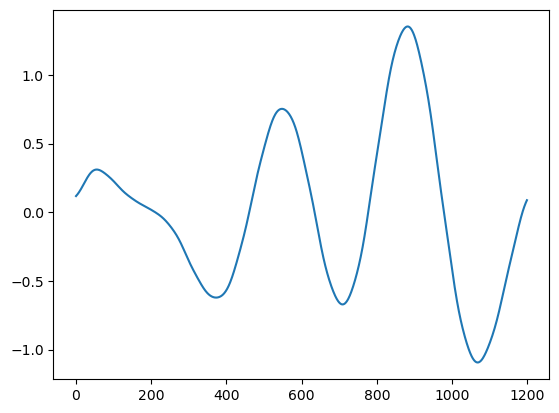

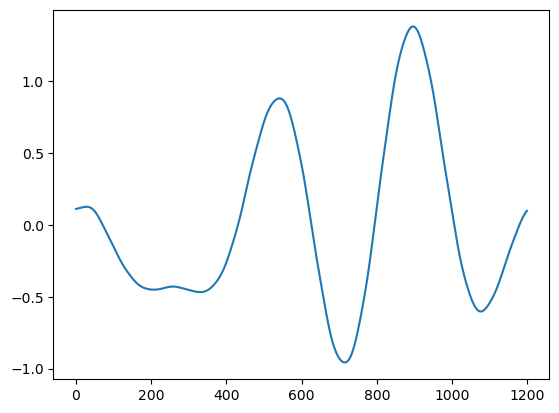

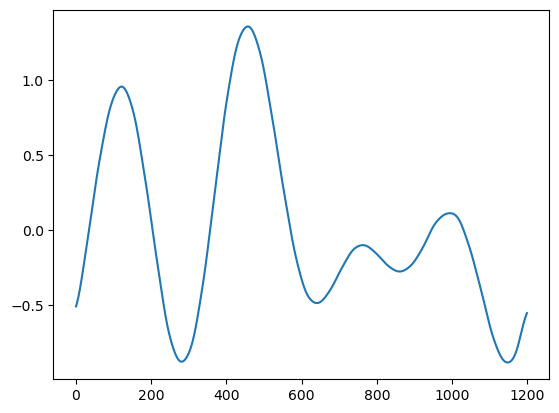

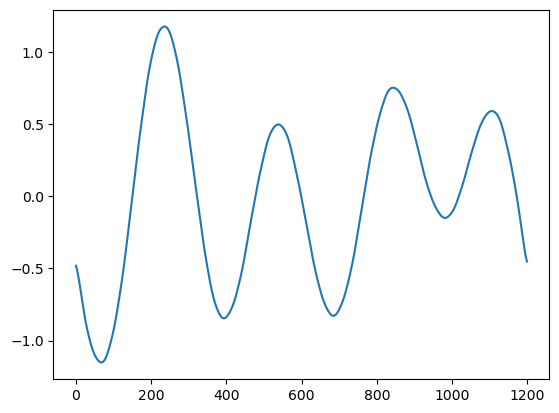

In [15]:
for i in range(num_promps):
    plt.plot(promp_trajs[i])
    plt.show()